# Deep Q-Learning

We're going to use Deep Q-Learning in order to learn a [cartpole](https://gymnasium.farama.org/environments/classic_control/cart_pole/) agent.  You'll notice the cartpole state space is continuous... Tabular Q-Learning won't work!

Let's start by setting up our environment.  Run the three cells below to install gymnasium on AWS, retrieve a `.npy` file of states, import everything relevant, and see what the observations look like.

After you run the first cell, I suggest commenting it out as you won't need to run it more than once.

In [1]:
'''
!pip install gymnasium gymnasium[classic_control]
!wget https://www.usna.edu/Users/cs/SD312/lab/13DeepQ/sampled_states.npy
'''

In [2]:
import gymnasium as gym
import numpy as np
import numpy.random
import torch
import torch.nn as nn
import torch.optim as optim
from collections import deque, namedtuple
import random
import plotly.graph_objects as go
from tqdm import tqdm

In [3]:
env = gym.make('CartPole-v1')
STATE_DIM = env.observation_space.shape[0]
N_ACTIONS = env.action_space.n
GAMMA = .99

print(f'State space is continuous in {STATE_DIM} dimensions, and there are {N_ACTIONS} actions.')

obs, info = env.reset()
print(f'For example, heres an observation: {obs}.')

State space is continuous in 4 dimensions, and there are 2 actions.
For example, heres an observation: [-0.00507046  0.01839253  0.00418391 -0.01715007].


## Hyperparameters

We have to decide a few things.
- What should $\epsilon$ be for our $\epsilon$-greedy exploration policy?
- How large should our replay be?
- How many datapoints should we pull from our replay to train on at a time (batch size)?
- What should our neural network look like? A good first step here is to make sure you understand what the dimensions of the input and output layers need to be - those aren't up to us, they are prescribed by the problem.

Choose some values, design your network.

Below we've also created a Replay - note that it's essentially a `deque` of limited size.  Make sure you understand that code!  In that replay, we are storing Transitions, each of which consists of a state, an action, a reward, and a next_state.  If the transition represents a failure (pole fell over or cart went off screen), the next_state will be `None`, 

In [4]:
EPSILON = .1 
REPLAY_LENGTH = 10000  
BATCH_SIZE = 32
LEARNING_RATE = .001

In [5]:
# Define a network and create an instance of it

In [6]:
Transition = namedtuple('Transition',
                        ('state', 'action', 'reward', 'next_state'))

class ReplayMemory:

    def __init__(self, capacity):
        self.memory = deque([], maxlen=capacity)

    def push(self, s, a, r, sp):
        """Save a transition"""
        s = torch.tensor(s, dtype=torch.float32)
        a = torch.tensor([a], dtype=torch.int64)
        r = torch.tensor([r], dtype=torch.float32)
        if sp is not None:
            sp = torch.tensor(sp, dtype=torch.float32)
        self.memory.append(Transition(s,a,r,sp))

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

memory=ReplayMemory(REPLAY_LENGTH) # ALGORITHM 1: Initialize replay memory D to capacity N

class QNetwork(nn.Module):
    def __init__(self, inputDim, outputDim):
        super(QNetwork, self).__init__()
        self.fc1 = nn.Linear(inputDim, 32) # 4 by 32
        self.fc2 = nn.Linear(32, 64)
        self.fc3 = nn.Linear(64, 128)
        self.fc4 = nn.Linear(128, 32) # Prevents overfitting
        self.fc5 = nn.Linear(32, outputDim) #32 by 2

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.relu(self.fc3(x))
        x = torch.relu(self.fc4(x))
        return self.fc5(x)
    
network = QNetwork(STATE_DIM, N_ACTIONS).to('cuda') # ALGORITHM 1: Initialize action-value function Q with random weights

## Policies!

The below functions define a greedy policy, an $\epsilon$-greedy policy, and a random policy.

In [7]:
def greedy_policy(network, states):
    '''
    Returns a tuple
    index 0 contains the Q-value of the best action for all states
    index 1 contains the index of the best action for all states
    '''
    with torch.no_grad():
        qs = network(states) # Get the q-values
        if qs.dim() == 1:   # If it's just a single state
            return torch.max(qs, dim=0) # Return the tuple of max info for that state
        return torch.max(qs, dim=1) # Return the tuple of max information for all states

def epsilon_greedy(network, state):
    '''
    Returns an action selected via epsilon-greedy
    '''
    if numpy.random.random() < EPSILON:
        return numpy.random.randint(N_ACTIONS)
    else:
        return greedy_policy(network, torch.tensor(state).to('cuda'))[1].item()

def random_policy():
    '''
    Chooses a random action.
    '''
    return numpy.random.randint(N_ACTIONS)

## Random performance

100 times, reset the environment and run it until truncation or termination, using a random policy.  Print out the average number of steps a random policy keeps the pole upright.

In [8]:
def random_policy_performance():
    total_steps = 0
    
    for _ in range(100):
        obs, info = env.reset()
        terminated = False
        steps = 0
        
        while not terminated:
            action = random_policy()
            obs, reward, terminated, truncated, info = env.step(action)
            steps += 1
            if truncated:
                break
        
        total_steps += steps
    
    average_steps = total_steps / 100
    print(f'Average number of steps: {average_steps}')
    
random_policy_performance()

Average number of steps: 19.53


## Evaluating training

We're going to reproduce the graphs on the right-hand side of Figure 2 in the paper in order to judge the smoothness of our training.  Create a function called `avg_qs`, which accepts as arguments your network and a tensor representing a group of states, which you should load from `sampled_states.npy`.  It should then do the following:

- in a `with torch.no_grad()` block, push the states through the network, producing some approximate Q-values
- calculate the maximum Q-value for each state
- average those maximum Q-values over all the states, resulting in a single scalar
- return that scalar (which should just be a number, not a tensor or numpy array - recall you can pull out the value from a tensor by using `.item()`.)

In [9]:
sampled_states = torch.tensor(np.load('sampled_states.npy'), dtype=torch.float32).to('cuda')

def avg_qs(network, states):
    with torch.no_grad():
        q = network(states)
        max_q, _ = torch.max(q, dim=1)
        return max_q.mean().item()


## Training your network

- Create an optimizer
- Choose a criterion
- Understand, then complete, this `train_model()` function, which implements the steps in Algorithm 1 from the word "Sample" to the mention of equation 3.

The initial steps in `train_model()` pull out the states, actions, and rewards from the batch, and turn them into cuda torch tensors.  `actual_next_mask` is the indices of the transitions in the batch that actually have a next state (ie, they don't represent a failure state, or in the parlance of the paper, are "non-terminal").  `next_states` is the torch tensor of all the next states for the non-terminal transitions.

In [10]:
optimizer = optim.Adam(network.parameters(), lr=LEARNING_RATE)
criterion = nn.MSELoss()

def train_model():
    if len(memory) < BATCH_SIZE:
        return

    transitions = memory.sample(BATCH_SIZE) # ALGORITHM 1: Sample random minibatch of transitions (φj , aj , rj , φj+1) from D

    # Extract tensors for states, actions, rewards, and next_states
    states = torch.cat([t.state.unsqueeze(0) for t in transitions], dim=0).to('cuda')
    actions = torch.cat([t.action.unsqueeze(0) for t in transitions], dim=0).to('cuda')
    rewards = torch.cat([t.reward.unsqueeze(0) for t in transitions], dim=0).to('cuda')
    actual_next_mask = [i for i in range(BATCH_SIZE) if transitions[i].next_state is not None]
    next_states = torch.cat([transition.next_state.unsqueeze(0) for transition in transitions if transition.next_state is not None], dim=0).to('cuda') 
    
    next_q = network(next_states)  # Get Q-values for the next state
    
    max_next_q, _ = torch.max(next_q, dim=1)  # Max Q-value for each next_state
    max_next_q = max_next_q.unsqueeze(1)  # [29, 1]

    # ALGORITHM 1: Update rewards for non-terminal states and keep reward for terminal states.
    rewards[actual_next_mask] += GAMMA * max_next_q # max_next_q would be 0 for terminal states
    
    # Calculate Q-values for the selected actions in the batch
    q = network(states).gather(1, actions.view(-1, 1))
 
    # Compute loss (mean squared error between predicted and target Q-values)
    loss = criterion(q.squeeze(), rewards.squeeze())

    # ALGORITHM 1: Perform a gradient descent step according to equation 3
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

## Create your samples, and call the training function

Implement the rest of Algorithm 1, calling your `train_model()` function where appropriate.

If the transition is terminal, the next_state should be `None`.

In [11]:
average_q_values = []

def train(num_episodes):
    best = float('-inf')
    for episode in range(num_episodes):  # ALGORITHM 1: for episode = 1, M do
        state, _ = env.reset()  # ALGORITHM 1: Initialize sequence s1 = {x1}
        terminated = False
        truncated = False
        total_reward = 0

        while not terminated: # ALGORITHM: for t= 1, T do
            # Change Epsilon - explore the state space aggresively (randomly) then shift to .05 to train on machine policy.
            if episode < num_episodes/4:
                EPSILON = 1
            else:
                EPSILON = .05
                
            action = epsilon_greedy(network, state)  # ALGORITHM 1: With probability epsilon select a random act aT otherwise select aT = maxa Q∗(φ(st), a; θ)
            next_state, reward, terminated, truncated, _ = env.step(action)  # ALGORITHM 1: Execute action at in emulator and observe reward and next_state

            # ALGORITHM 1: Store transition in replay memory
            memory.push(state, action, reward, next_state if not terminated else None) # ALGORITHM 1: Store transition (φt, at, rt, φt+1) in D

            # Train the model
            train_model()

            # Update state and  total reward
            state = next_state
            total_reward += reward
        
        q_max = avg_qs(network, sampled_states)
        average_q_values.append(q_max)
        
        if(best < q_max):
            best = q_max
            torch.save(network,"BestModel")
            
        if episode % 10 == 0:
            print(f"Episode {episode}, Total Reward: {total_reward}, Average Action Value {q_max}")
        
train(250)

Episode 0, Total Reward: 11.0, Average Action Value 0.0026641408912837505
Episode 10, Total Reward: 9.0, Average Action Value 3.7705371379852295
Episode 20, Total Reward: 76.0, Average Action Value 8.5397310256958
Episode 30, Total Reward: 92.0, Average Action Value 10.10437297821045
Episode 40, Total Reward: 69.0, Average Action Value 13.842369079589844
Episode 50, Total Reward: 68.0, Average Action Value 15.014334678649902
Episode 60, Total Reward: 210.0, Average Action Value 26.11549186706543
Episode 70, Total Reward: 169.0, Average Action Value 28.02545928955078
Episode 80, Total Reward: 150.0, Average Action Value 28.976728439331055
Episode 90, Total Reward: 208.0, Average Action Value 28.65618324279785
Episode 100, Total Reward: 377.0, Average Action Value 48.51279067993164
Episode 110, Total Reward: 305.0, Average Action Value 36.394649505615234
Episode 120, Total Reward: 267.0, Average Action Value 39.58774185180664
Episode 130, Total Reward: 295.0, Average Action Value 46.5761

## Evaluating the smoothness of your training

In the above training loop, keep track of the average maximum Q values for the `sampled_states` you loaded above.  Make a plot displaying the average Q values of the sampled states over time.

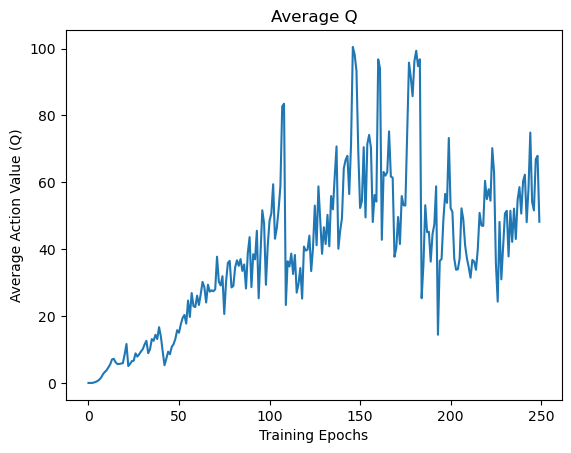

In [12]:
import matplotlib.pyplot as plt
plt.plot(average_q_values)
plt.xlabel('Training Epochs')
plt.ylabel('Average Action Value (Q)')
plt.title('Average Q')
plt.show()

## Evaluating your model's performance

1000 times, use a greedy policy based off your model to run until termination or truncation.  Keep track of the number of steps that pass on each run before it stops (each trial will run a maximum of 500 steps before truncation - of course, it may terminate sooner if the pole falls or the cart goes off the screen).  Print out that average.

In [13]:
network = torch.load("BestModel")
def evaluate_model(num_episodes, max_steps):
    total_steps = 0

    for episode in range(num_episodes):
        state, _ = env.reset()  # Reset the environment
        terminated = False
        truncated = False
        steps = 0

        while not terminated and steps < max_steps and not truncated:
            state_tensor = torch.tensor(state, dtype=torch.float32).unsqueeze(0).to('cuda')
            
            # Get the action recommended by the model
            action = greedy_policy(network, state_tensor)[1].item()

            # Take the action in the environment
            next_state, reward, terminated, truncated, _ = env.step(action)
            
            # Update the state and stepcount
            state = next_state
            steps += 1
        
        total_steps += steps
    
    average_steps = total_steps / num_episodes
    print(f"Average steps per episode: {average_steps}")

evaluate_model(1000, 500)

Average steps per episode: 500.0


The largest change I made was REPLAY_LENGTH = 1000 to REPLAY_LENGTH = 10000.
Epsilon adjustments from 1 for the first quarter of the episodes then shift to .05 per something similar the paper does.
Implemented saving best Average Action Value model.

Max average step side per episode for this problem is 500 so this model reaches the optimal solution.